
<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/Banner_IA2_1.png" style="width:1500px;heigth:100px">



# <center> **13. UNET: A special autoencoder** </center>



## <span style="color:red"> Outline </span> 
1. **Semantic segmentation**
2. **UNET: an autoencoder for segmentation**
3. **UNET application 1**
4. **UNET application 2**


In [ ]:
#@title 1. MONTAR EL DRIVE  (If you are in in colab){ display-mode: "form" }
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/course-IA2')
print(os.getcwd())

In [ ]:
#@title Load libraries and remember to configurate notebook in GPU


import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import cv2

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# **1. Semantic segmentation**

Image classification gives a **discrete labeled answer (image dimension)** from an image input with **objects of interest** into a particular scene. This task namely is much more complex that include localization, detection and spatial object boundary. 

For **_semantic segmentation_** specifically the task is associate **to each pixel** a semantic label produced from a machine learning algortihm. This task is know as a **dense prediction** and result useful for many different scenarios, areas and applications. In figure you can observe applications related with **autonomous vehicles** for planning and detection of traffic signs, to support **biomedical image diagnosis**, for **agriculture precision** to reduce herbicides and smart control. 

<center> 
<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/segmentation.png" style="width:700px;heigth:100px">
</center>

Nowadays, there exist more sophisticated models that try **instance segmentation** with the idea to obtain a per-pixel segmentation but for **multiclass** problems. 

# **2. UNET: an autoencoder to segmentation**



<center> 
<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/unet.png"  width="700">
</center>

### **Transposed deconvolution**

This is a special module on UNET also named deconvolution or fractionally strided convolution. 

- How works convolution (with no padding)?

<center> 
<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/convolucion.png" width="400">
</center>

- How deconvolve? (from [4](https://medium.com/activating-robotic-minds/up-sampling-with-transposed-convolution-9ae4f2df52d0))

For this special autoencoders we want to going backward and reproduce original input, in one-to-many relationships.


<center> 
<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/deconvolution.png" width="400">
</center>

The main idea behind is **transposed convolution**. For doing so, we need to rearranged kernel matrix and understand convolution as linear matricial operation, as: 

1. Convolution as matricial operation: re-arrange kernel matrix

<center> 
<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/conv_mat.png" width="800">
</center>

Pay attention that original image is ($4 \times 4$) and kernel is ($3 \times 3$))
2. Transpose such operation to obtain the deconvolution. 

<center> 
<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/deconv_mat.png" width="500">
</center>

So, how looks a UNET-code... **go to the action!**

In [ ]:
#@title **code** a function to create the pair of UNET convolutions
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x
  

In [ ]:
 #@title **code** a nice UNET function
 def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model


# **3. UNET application 1**
### **Nuclei segmentation**

A very important task is the automate nucleus detection and segmentation. The task of classify, identify and segment cell nuclei it is very important in many clinical task, such as, to quantify disorders, disease related with cancer, understand treatment responses, among much others.  The image data was taken from [data-science-bowl-2018](https://www.kaggle.com/c/data-science-bowl-2018)

<center> 
<img src="https://storage.googleapis.com/kaggle-media/competitions/dsb-2018/dsb.jpg" width="400">
</center>





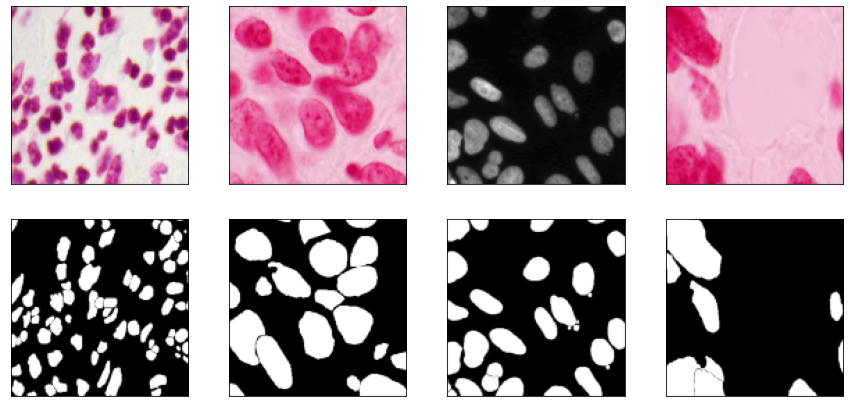

In [ ]:
#@title **code** to show some examples
path = '/... path of course .../ai-2-uis-professor/data/bowl-2018/'

plt.figure(figsize=(15,15))
plt.subplot(441), plt.imshow(cv2.imread(os.path.join(path,'imgs', '71.png'))), plt.xticks([]), plt.yticks([]);
plt.subplot(442), plt.imshow(cv2.imread(os.path.join(path,'imgs', '68.png'))), plt.xticks([]), plt.yticks([]);
plt.subplot(443), plt.imshow(cv2.imread(os.path.join(path,'imgs', '94.png'))),plt.xticks([]), plt.yticks([]); 
plt.subplot(444), plt.imshow(cv2.imread(os.path.join(path,'imgs', '114.png'))),plt.xticks([]), plt.yticks([]); 
plt.subplot(445), plt.imshow(cv2.imread(os.path.join(path,'masks', '71.png'))), plt.xticks([]), plt.yticks([]);
plt.subplot(446), plt.imshow(cv2.imread(os.path.join(path,'masks', '68.png'))), plt.xticks([]), plt.yticks([]);
plt.subplot(447), plt.imshow(cv2.imread(os.path.join(path,'masks', '94.png'))),plt.xticks([]), plt.yticks([]); 
plt.subplot(448), plt.imshow(cv2.imread(os.path.join(path,'masks', '114.png'))),plt.xticks([]), plt.yticks([]); 


In [ ]:
#@title **code** To load complete dataset
path = '/content/drive/My Drive/main/academic/courses/2020-UIS-MachineAnsDeepLearning/ai-2-uis-professor/data/bowl-2018/'


imgs=os.listdir(path+'imgs')
masks=os.listdir(path+'masks')

imgs.sort()
masks.sort()

imgs=[os.path.join(path,'imgs', img) for img in imgs]
masks=[os.path.join(path,'masks', mask) for mask in masks]

imgs_l = [cv2.imread(img) for img in imgs]
masks_l =[cv2.imread(mask,0) for mask in masks]

print(len(imgs_l), len(masks_l), imgs_l[0].shape) 
X = np.array(imgs_l)/255.0
y =np.array(masks_l)/255.0
print(X.shape, y.shape, np.max(X), np.min(X)) 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
#@title **code** charge, prepare and tunne the model
input_img = Input((128, 128, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

In [ ]:
#@title **code** train the model!
earlystopper = EarlyStopping(patience=3, verbose=1)
checkpointer = ModelCheckpoint('model_cell_unet.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, y_train, batch_size=32, 
                    callbacks=[earlystopper, checkpointer],
                    epochs=50,validation_data=(X_valid, y_valid))


In [ ]:
#@title **code** To show train and test performance
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [ ]:
#@title **code** predict 
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

preds_val.shape, preds_train.shape
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

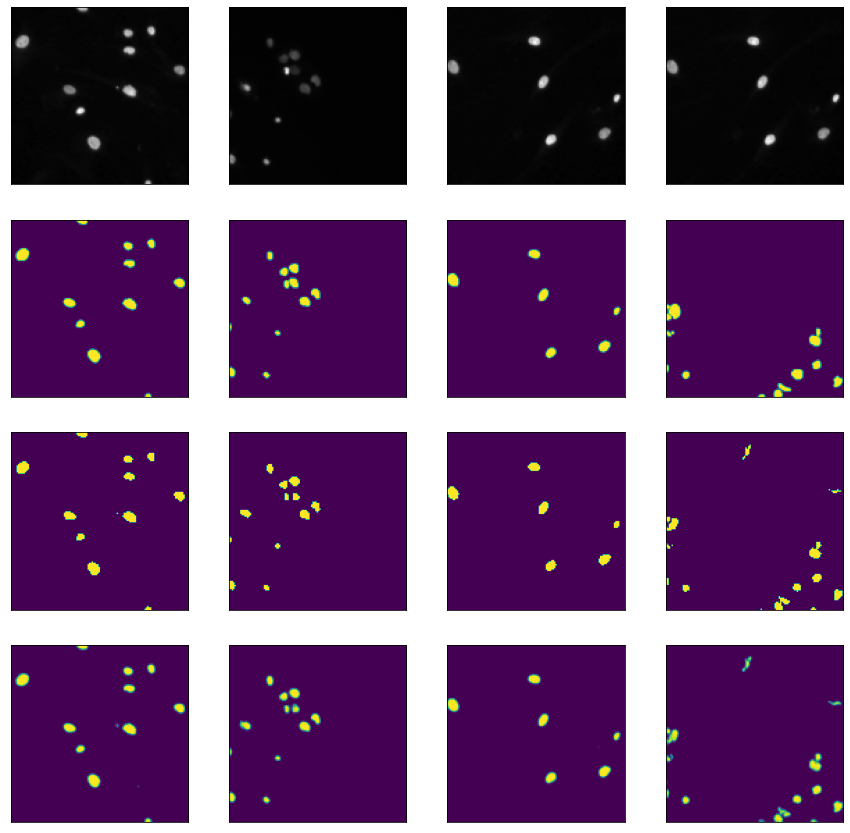

In [ ]:
#@title **code** Some results
ex_1 =  21#@param {type:"integer"}
ex_2 = 15 #@param {type:"integer"}
ex_3 = 23 #@param {type:"integer"}
ex_4 =  0#@param {type:"integer"}

plt.figure(figsize=(15,15))

plt.subplot(441), plt.imshow(X_valid[ex_1]), plt.xticks([]), plt.yticks([]);
plt.subplot(442), plt.imshow(X_valid[ex_2]), plt.xticks([]), plt.yticks([]);
plt.subplot(443), plt.imshow(X_valid[ex_3]), plt.xticks([]), plt.yticks([]);
plt.subplot(444), plt.imshow(X_valid[ex_4]), plt.xticks([]), plt.yticks([]);

plt.subplot(445), plt.imshow(y_valid[ex_1]), plt.xticks([]), plt.yticks([]);
plt.subplot(446), plt.imshow(y_valid[ex_2]), plt.xticks([]), plt.yticks([]);
plt.subplot(447), plt.imshow(y_valid[ex_3]), plt.xticks([]), plt.yticks([]);
plt.subplot(448), plt.imshow(y_valid[ex_4]), plt.xticks([]), plt.yticks([]);

plt.subplot(449), plt.imshow(np.squeeze(preds_val_t[ex_1])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,10), plt.imshow(np.squeeze(preds_val_t[ex_2])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,11), plt.imshow(np.squeeze(preds_val_t[ex_3])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,12), plt.imshow(np.squeeze(preds_val_t[ex_4])), plt.xticks([]), plt.yticks([]);

plt.subplot(4,4,13), plt.imshow(np.squeeze(preds_val[ex_1])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,14), plt.imshow(np.squeeze(preds_val[ex_2])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,15), plt.imshow(np.squeeze(preds_val[ex_3])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,16), plt.imshow(np.squeeze(preds_val[ex_4])), plt.xticks([]), plt.yticks([]);

<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/icon1.png" width="200">

- Try a more restrictive data learning. Only take 50 % and 20% of training data. Visualize and analyze the results. What happened?

# **4. UNET application 2**


Seismic data is captured from seismic reflection,  similar to X-ray, sonar and echolocation. In this dataset is collected a set of images that try to detect several areas of the world where there are vast quantities of salt in the subsurface. The sequence of images was taken from dataset [tgs-salt-identification-challenge](https://www.kaggle.com/c/tgs-salt-identification-challenge/data) 


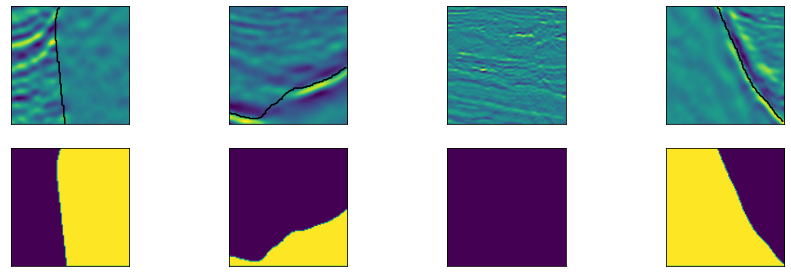

In [ ]:
# @title **code** To visualize segmentation challenge

path = '/content/drive/My Drive/main/academic/courses/2020-UIS-MachineAnsDeepLearning/ai-2-uis-professor/data/tgsalt/'

plt.figure(figsize=(15,10))
ax1= plt.subplot(441), plt.imshow(cv2.imread(os.path.join(path,'imgs', '711.png'),0)), plt.xticks([]), plt.yticks([]);
ax1= plt.contour(cv2.imread(os.path.join(path,'masks', '711.png'),0), colors='k', levels=[0.5]);
ax2= plt.subplot(442), plt.imshow(cv2.imread(os.path.join(path,'imgs', '618.png'),0)), plt.xticks([]), plt.yticks([]);
ax2= plt.contour(cv2.imread(os.path.join(path,'masks', '618.png'),0), colors='k', levels=[0.5]);
ax3=plt.subplot(443), plt.imshow(cv2.imread(os.path.join(path,'imgs', '914.png'),0)),plt.xticks([]), plt.yticks([]); 
#ax3= plt.contour(cv2.imread(os.path.join(path,'masks', '914.png'),0), colors='k', levels=[0.5]);
ax4=plt.subplot(444), plt.imshow(cv2.imread(os.path.join(path,'imgs', '1114.png'),0)),plt.xticks([]), plt.yticks([]); 
ax4= plt.contour(cv2.imread(os.path.join(path,'masks', '1114.png'),0), colors='k', levels=[0.5]);
ax5=plt.subplot(445), plt.imshow(cv2.imread(os.path.join(path,'masks', '711.png'),0)), plt.xticks([]), plt.yticks([]);
ax6=plt.subplot(446), plt.imshow(cv2.imread(os.path.join(path,'masks', '618.png'),0)), plt.xticks([]), plt.yticks([]);
ax7=plt.subplot(447), plt.imshow(cv2.imread(os.path.join(path,'masks', '914.png'),0)),plt.xticks([]), plt.yticks([]); 
ax8=plt.subplot(448), plt.imshow(cv2.imread(os.path.join(path,'masks', '1114.png'),0)),plt.xticks([]), plt.yticks([]); 


In [ ]:
# @title **code** To load pre-trained unet model
model = tf.keras.models.load_model('models/model_tgsalt_unet.h5')
model.summary()

In [ ]:
#@title **code** predict 
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

preds_val.shape, preds_train.shape
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

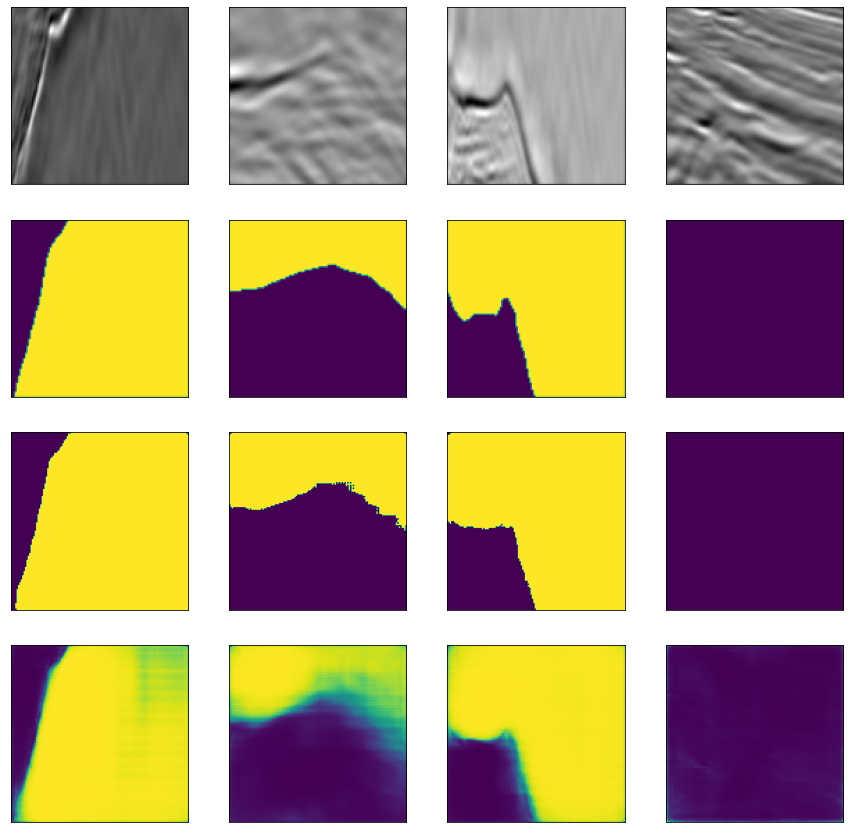

In [ ]:
#@title **code professor** To show some results

#@title **code** Some results
ex_1 =  21#@param {type:"integer"}
ex_2 = 15 #@param {type:"integer"}
ex_3 = 23 #@param {type:"integer"}
ex_4 =  300#@param {type:"integer"}

plt.figure(figsize=(15,15))

plt.subplot(441), plt.imshow(X_valid[ex_1]), plt.xticks([]), plt.yticks([]);
plt.subplot(442), plt.imshow(X_valid[ex_2]), plt.xticks([]), plt.yticks([]);
plt.subplot(443), plt.imshow(X_valid[ex_3]), plt.xticks([]), plt.yticks([]);
plt.subplot(444), plt.imshow(X_valid[ex_4]), plt.xticks([]), plt.yticks([]);

plt.subplot(445), plt.imshow(y_valid[ex_1]), plt.xticks([]), plt.yticks([]);
plt.subplot(446), plt.imshow(y_valid[ex_2]), plt.xticks([]), plt.yticks([]);
plt.subplot(447), plt.imshow(y_valid[ex_3]), plt.xticks([]), plt.yticks([]);
plt.subplot(448), plt.imshow(y_valid[ex_4]), plt.xticks([]), plt.yticks([]);

plt.subplot(449), plt.imshow(np.squeeze(preds_val_t[ex_1])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,10), plt.imshow(np.squeeze(preds_val_t[ex_2])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,11), plt.imshow(np.squeeze(preds_val_t[ex_3])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,12), plt.imshow(np.squeeze(preds_val_t[ex_4])), plt.xticks([]), plt.yticks([]);

plt.subplot(4,4,13), plt.imshow(np.squeeze(preds_val[ex_1])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,14), plt.imshow(np.squeeze(preds_val[ex_2])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,15), plt.imshow(np.squeeze(preds_val[ex_3])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,16), plt.imshow(np.squeeze(preds_val[ex_4])), plt.xticks([]), plt.yticks([]);

<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/icon1.png" width="200">

- Evaluate other images and enjoy!
- put contours over images to analyze model perfomance




<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/icon1.png" width="200">

### **If we have time or to Homework**

Run the model with whole images, built your own model and try with different configurations. 

- Try to test the model with a two different data configurations.     
  - firts experiment only take 50% of data for training, while for  second experiment take 80 % for training. 
  -Use a different optimizer, ephocs, and others parameters
- Propose a new architecture with different layers, change set of neurons and with different dropout



# **Some conclusions**

- Nowadays, the UNet is the one of the most representative architectures to segment images from a deep learning perspective, with impresive results in many areas. 

- Of course there exist many variations of these architecture to solve some segmentation challenges. 

- Also, there exist other tasks are recognition, multiple instance segmentation that requires more sophisticated nets. 

# **References**

[1. U-Net: Convolutional Networks for Biomedical
Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf)


[2. A guide to convolution arithmetic for deep learning](https://arxiv.org/abs/1603.07285)

[3. Deconvolution and Checkerboard Artifacts](https://distill.pub/2016/deconv-checkerboard/)

[4. Transposed convolution](https://medium.com/activating-robotic-minds/up-sampling-with-transposed-convolution-9ae4f2df52d0)

<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/cv/cv-uis-student/raw/master/imgs/bannerThanks.jpg" style="width:1000px;">